Resolver el problema anterior utilizando Embeddings y recordar hacer un\
padding. Luego, armar una nueva arquitectura utilizando capas convoluciones\
1D en lugar de capas densas. Comparar la precisión entre ambos problemas y\
el mejor resultado obtenido del punto anterior.

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=10000)

word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
#Busquemos la review mas larga en todos los datos
print(len(max(x_train, key=len)), len(max(x_test, key=len)))

2494 2315


In [ ]:
def preprocess(X):
    m = X.shape[0]
    
    data = np.zeros((m, 2500), dtype=float)

    for i in range(m):
        y = np.asarray(X[i])
        data[i,:len(y)] += y

    return data

In [ ]:
Xtrain = preprocess(x_train)
Xtest = preprocess(x_test)

print(Xtrain.shape, Xtest.shape)

(25000, 2500) (25000, 2500)


In [ ]:
def plot(hist):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax1.plot(hist.history['loss'], label='BCE')
    ax1.plot(hist.history['val_loss'], label='val_BCE')
    ax1.set_xlabel('Epocas', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.legend(loc='best')

    ax2.plot(hist.history['binary_accuracy'], label='BCE')
    ax2.plot(hist.history['val_binary_accuracy'], label='val_BCE')
    ax2.set_xlabel('Epocas', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax2.legend(loc='best')

    fig.tight_layout()
    plt.show()
    return None

Ya tenemos nuestros datos. Para el primer punto solo hay que agregar una capa\
de embedding a las arquitecturas del problema anterior.

In [ ]:
keras.backend.clear_session()

opt = keras.optimizers.Adam(learning_rate=.001)
reg = keras.regularizers.L2(0.02)

input = keras.layers.Input(shape=(2500,))

embed = keras.layers.Embedding(10000, 75, input_length=2500)(input)

flat = keras.layers.Flatten()(embed)

l1 = keras.layers.Dense(25, activation='relu', use_bias=True, 
                        kernel_regularizer=reg)(flat)
drop1 = keras.layers.Dropout(rate=0.3)(l1)

l2 = keras.layers.Dense(25, activation='relu', use_bias=True, 
                        kernel_regularizer=reg)(drop1)
drop2 = keras.layers.Dropout(rate=0.3)(l2)

#l3 = keras.layers.Dense(10, activation='relu', use_bias=True, 
#                        kernel_regularizer=reg)(drop2)
#drop3 = keras.layers.Dropout(rate=0)(l3)

output = keras.layers.Dense(1, activation='sigmoid', use_bias=True)(drop2)

model = keras.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2500)]            0         
                                                                 
 embedding (Embedding)       (None, 2500, 75)          750000    
                                                                 
 flatten (Flatten)           (None, 187500)            0         
                                                                 
 dense (Dense)               (None, 25)                4687525   
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0     

In [ ]:
model.compile(optimizer=opt, 
              loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=[keras.metrics.BinaryAccuracy(threshold=.8)]
              )

hist = model.fit(Xtrain, y_train, validation_data=(Xtest, y_test), epochs=15, 
                   batch_size=50, verbose=2)

keras.backend.clear_session()

Epoch 1/15
500/500 - 71s - loss: 0.8593 - binary_accuracy: 0.5534 - val_loss: 0.6599 - val_binary_accuracy: 0.6576 - 71s/epoch - 142ms/step
Epoch 2/15
500/500 - 75s - loss: 0.6135 - binary_accuracy: 0.7650 - val_loss: 0.5615 - val_binary_accuracy: 0.8140 - 75s/epoch - 149ms/step
Epoch 3/15
500/500 - 77s - loss: 0.5348 - binary_accuracy: 0.8226 - val_loss: 0.5346 - val_binary_accuracy: 0.8142 - 77s/epoch - 153ms/step
Epoch 4/15
500/500 - 69s - loss: 0.5098 - binary_accuracy: 0.8466 - val_loss: 0.5594 - val_binary_accuracy: 0.8376 - 69s/epoch - 138ms/step
Epoch 5/15
500/500 - 73s - loss: 0.4841 - binary_accuracy: 0.8738 - val_loss: 0.5861 - val_binary_accuracy: 0.8390 - 73s/epoch - 146ms/step
Epoch 6/15
500/500 - 70s - loss: 0.4808 - binary_accuracy: 0.8894 - val_loss: 0.6316 - val_binary_accuracy: 0.8507 - 70s/epoch - 139ms/step
Epoch 7/15
500/500 - 72s - loss: 0.4603 - binary_accuracy: 0.9094 - val_loss: 0.6107 - val_binary_accuracy: 0.8454 - 72s/epoch - 143ms/step
Epoch 8/15
500/500 -

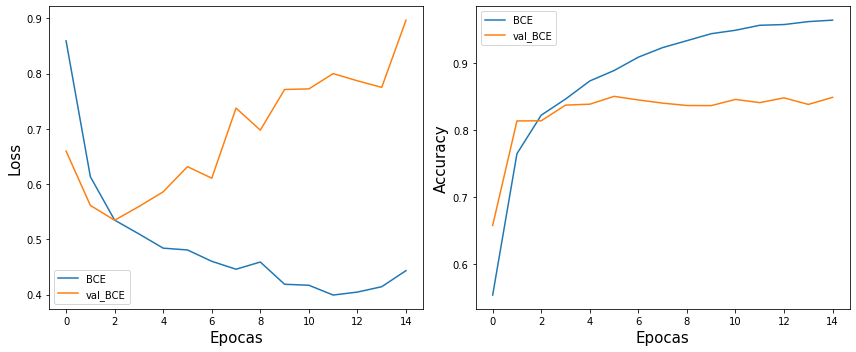

In [ ]:
plot(hist)

In [ ]:
model.predict(Xtest[0:10])

array([[0.00578609],
       [0.99569106],
       [0.99080235],
       [0.0359014 ],
       [0.931407  ],
       [0.08247241],
       [0.9067985 ],
       [0.00580797],
       [0.99194056],
       [0.9440868 ]], dtype=float32)

Ahora la red convolucional

In [ ]:
keras.backend.clear_session()

opt = keras.optimizers.Adam(learning_rate=.001)
reg = keras.regularizers.L2(0.008)

input = keras.layers.Input(shape=(2500,))

embed = keras.layers.Embedding(10000, 50, input_length=2500, 
                               embeddings_regularizer=reg)(input)

l1 = keras.layers.Conv1D(filters=64, kernel_size=3, 
                         kernel_regularizer=reg)(embed)

l2 = keras.layers.Conv1D(filters=32, kernel_size=3, kernel_regularizer=reg)(l1)

flat = keras.layers.Flatten()(l2)

output = keras.layers.Dense(1, activation='sigmoid', 
                            kernel_regularizer=reg)(flat)


model = keras.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2500)]            0         
                                                                 
 embedding (Embedding)       (None, 2500, 50)          500000    
                                                                 
 conv1d (Conv1D)             (None, 2498, 64)          9664      
                                                                 
 conv1d_1 (Conv1D)           (None, 2496, 32)          6176      
                                                                 
 flatten (Flatten)           (None, 79872)             0         
                                                                 
 dense (Dense)               (None, 1)                 79873     
                                                                 
Total params: 595,713
Trainable params: 595,713
Non-trainable

In [ ]:
model.compile(optimizer=opt, 
              loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=[keras.metrics.BinaryAccuracy(threshold=.8)]
              )

hist = model.fit(Xtrain, y_train, validation_data=(Xtest, y_test), epochs=15, 
                   batch_size=50, verbose=1)

keras.backend.clear_session()

Epoch 1/15
500/500 [==============================] - 224s 446ms/step - loss: 0.9162 - binary_accuracy: 0.6016 - val_loss: 0.6070 - val_binary_accuracy: 0.7043
Epoch 2/15
500/500 [==============================] - 220s 441ms/step - loss: 0.5671 - binary_accuracy: 0.7531 - val_loss: 0.5553 - val_binary_accuracy: 0.7100
Epoch 3/15
500/500 [==============================] - 229s 457ms/step - loss: 0.5262 - binary_accuracy: 0.7782 - val_loss: 0.5384 - val_binary_accuracy: 0.8067
Epoch 4/15
500/500 [==============================] - 253s 507ms/step - loss: 0.5135 - binary_accuracy: 0.7882 - val_loss: 0.5181 - val_binary_accuracy: 0.7344
Epoch 5/15
500/500 [==============================] - 234s 469ms/step - loss: 0.5039 - binary_accuracy: 0.7947 - val_loss: 0.5154 - val_binary_accuracy: 0.7539
Epoch 6/15
500/500 [==============================] - 221s 441ms/step - loss: 0.4962 - binary_accuracy: 0.7980 - val_loss: 0.5318 - val_binary_accuracy: 0.8392
Epoch 7/15
500/500 [====================

KeyboardInterrupt: ignored

In [ ]:
plot(hist)

NameError: ignored

In [ ]:
keras.backend.clear_session()

opt = keras.optimizers.Adam(learning_rate=.00005)
dropout_rate=.5

input = keras.layers.Input(shape=(2500,))

embed = keras.layers.Embedding(10000, 50, input_length=2500)(input)
drop1 = keras.layers.Dropout(rate=dropout_rate)(embed)
BN1 = keras.layers.BatchNormalization()(drop1)

conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(BN1)
max1 = keras.layers.MaxPooling1D()(conv1)
drop2 = keras.layers.Dropout(rate=dropout_rate)(max1)
BN2 = keras.layers.BatchNormalization()(drop2)

conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(BN2)
max2 = keras.layers.MaxPooling1D()(conv2)
drop3 = keras.layers.Dropout(rate=dropout_rate)(max2)
BN3 = keras.layers.BatchNormalization()(drop3)

flat = keras.layers.Flatten()(BN3)

output = keras.layers.Dense(1, activation='linear')(flat)


model = keras.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2500)]            0         
                                                                 
 embedding (Embedding)       (None, 2500, 50)          500000    
                                                                 
 dropout (Dropout)           (None, 2500, 50)          0         
                                                                 
 batch_normalization (BatchN  (None, 2500, 50)         200       
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 2498, 32)          4832      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1249, 32)         0         
 )                                                           

In [ ]:
model.compile(optimizer=opt, 
              loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[keras.metrics.BinaryAccuracy()]
              )

hist = model.fit(Xtrain, y_train, validation_data=(Xtest, y_test), epochs=50, 
                   batch_size=128, verbose=1)

keras.backend.clear_session()

Epoch 1/50
196/196 [==============================] - 319s 2s/step - loss: 0.8885 - binary_accuracy: 0.4995 - val_loss: 0.6952 - val_binary_accuracy: 0.5000
Epoch 2/50
196/196 [==============================] - 316s 2s/step - loss: 0.8674 - binary_accuracy: 0.5046 - val_loss: 0.7329 - val_binary_accuracy: 0.5033
Epoch 3/50
196/196 [==============================] - 314s 2s/step - loss: 0.8586 - binary_accuracy: 0.5051 - val_loss: 0.7389 - val_binary_accuracy: 0.5110
Epoch 4/50
196/196 [==============================] - 316s 2s/step - loss: 0.8486 - binary_accuracy: 0.5029 - val_loss: 0.7247 - val_binary_accuracy: 0.5253
Epoch 5/50
196/196 [==============================] - 316s 2s/step - loss: 0.8341 - binary_accuracy: 0.5064 - val_loss: 0.7283 - val_binary_accuracy: 0.5400
Epoch 6/50
196/196 [==============================] - 316s 2s/step - loss: 0.8144 - binary_accuracy: 0.5101 - val_loss: 0.7608 - val_binary_accuracy: 0.5102
Epoch 7/50
196/196 [==============================] - 316s

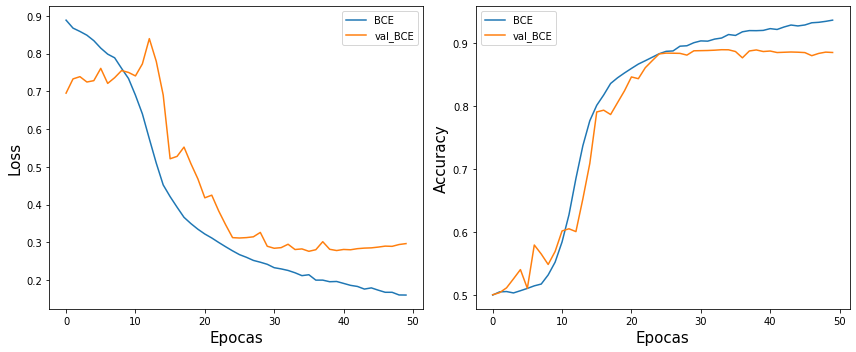

In [ ]:
plot(hist)